## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


У столбца date тип object(строка).

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [8]:
data['date'] = pd.to_datetime(data['date'])
data.groupby(['group'])['date'].agg(['min','max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


Даты проведения тестирования в обоих группах совпадают.  
Тестирование проводилось с 2021-01-02 по 2021-01-24

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [27]:
data_group = data.groupby(['group']).agg({
    'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'
}).reset_index().rename(columns={'user_id':'user_count'})

print(f"Количество посещений в группе A = {data_group.iloc[0]['user_count']}")
print(f"Количество посещений в группе B = {data_group.iloc[1]['user_count']}")
print(f"Суммарное количество покупок в группе A = {data_group.iloc[0]['purchase']}")
print(f"Суммарное количество покупок в группе B = {data_group.iloc[1]['purchase']}")
print(f"Сумма всех покупок в группе A = {data_group.iloc[0]['price']/1000000} млн.руб")
print(f"Сумма всех покупок в группе B = {data_group.iloc[1]['price']/1000000} млн.руб")

Количество посещений в группе A = 147202
Количество посещений в группе B = 147276
Суммарное количество покупок в группе A = 17723
Суммарное количество покупок в группе B = 17514
Сумма всех покупок в группе A = 1436.26 млн.руб
Сумма всех покупок в группе B = 1554.1 млн.руб


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [33]:
set_a = set(data[data['group']=='A']['user_id'])
set_b = data[data['group']=='B']['user_id']

user_intersection = set_a.intersection(set_b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [34]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

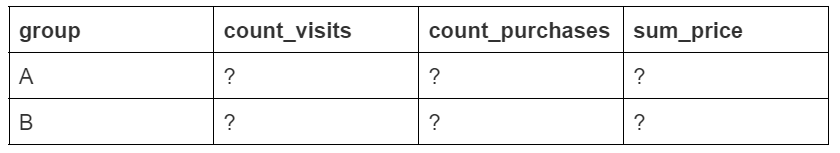
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [39]:
data_group = updated_data.groupby(['group']).agg({
    'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'
}).reset_index().rename(columns={
    "user_id" : "count_visits",
    "purchase" : "count_purchases",
    "price" : "sum_price"
})
data_group

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений сайта в группах A и B практически не отличаются. Можем говорить о сбалансированности выборок.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [43]:
data_group['conversion'] = data_group['count_purchases'] / data_group['count_visits'] * 100
data_group['mean_check'] = data_group['sum_price'] / data_group['count_purchases']
data_group

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вариант A эффективнее по конверсии, а вариант B эффективнее по среднему чеку.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [47]:
pivot_data = updated_data.pivot_table(
    values = 'purchase',
    index = 'group',
    columns= 'price',
    aggfunc= 'count'
)
pivot_data

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,127820,5182,5271,1832,3478,1724
B,128091,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='price', ylabel='group'>

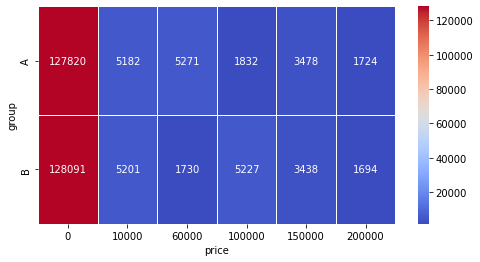

In [50]:
fig = plt.figure(figsize=(8,4))
sns.heatmap(pivot_data, annot=True, linewidths=.5, fmt='d', cmap='coolwarm')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

У группы A покупательская способность выше по турам за 60000, 150000 и 200000. По турам за 10000 и 100000 покупательская способность выше у группы B.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [62]:
data_cum = updated_data.groupby(['date','group']).agg({
    'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'
}).reset_index().rename(columns={
    "user_id" : "count_visits",
    "purchase" : "count_purchases",
    "price" : "sum_price"
})

data_cum['conversion'] = data_cum['count_purchases'] / data_cum['count_visits'] * 100
data_cum['mean_check'] = data_cum['sum_price'] / data_cum['count_purchases']

data_cum[data_cum['date']=='2021-01-03']

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [65]:
data_cum['cum_users_count'] = data_cum.groupby(['group'])['count_visits'].cumsum() # кумулятивное количество посещений страницы
data_cum['cum_count_purchases'] = data_cum.groupby(['group'])['count_purchases'].cumsum() # кумулятивное количество покупок
data_cum['cum_sum_price'] = data_cum.groupby(['group'])['sum_price'].cumsum() # кумулятивная сумма покупок

data_cum['cum_conversion'] = data_cum['cum_count_purchases'] / data_cum['cum_users_count'] * 100
data_cum['cum_mean_check'] = data_cum['cum_sum_price'] / data_cum['cum_count_purchases']

data_cum[(data_cum['date']=='2021-01-20') | (data_cum['date']=='2021-01-12')]
# 20 января в группе B кумулятивная конверсия = 11.90
# 12 января в группе A кумулятивный средний чек = 81492

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,11.906698,81491.827275
21,2021-01-12,B,6635,807,70560000,12.162773,87434.944238,69251,8236,727670000,11.892969,88352.355512
36,2021-01-20,A,6533,749,58710000,11.464871,78384.512684,121506,14561,1179590000,11.983770,81010.232814
37,2021-01-20,B,6685,790,69250000,11.817502,87658.227848,121857,14496,1286900000,11.895911,88776.214128


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

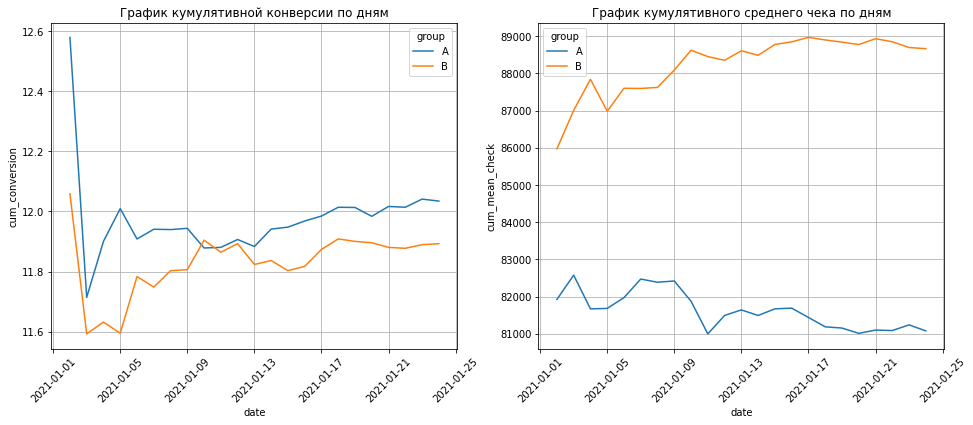

In [69]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=data_cum, hue='group', ax=axes[0])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=data_cum, hue='group', ax=axes[1])
# задаём подпись к графику
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
axes[0].grid(True)
axes[1].grid(True);

Конверсия: с 2021-01-09 прекратилсь резкие скачки, метрики стабилизировались. Конверсия группы A стабильно выше конверсии группы B.  
Средний чек: резкий скачки прекратились с 2021-01-13, средний чек группы B выше среднего чека группы A на протяжении всего времени эксперимента.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [78]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 

_, p_value = proportions_ztest(
    count=data_group['count_purchases'], #число "успехов"
    nobs=data_group['count_visits'], #общее число наблюдений
    alternative='larger',
)
print('p-value:', round(p_value, 2))
 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value: 0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

p-value больше уровня значимости, значит конверсии в группах A и B равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [100]:
# доверительный интервал пропорции
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    #print(eps)
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# доверительный интервал разницы пропорций
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


a_data = updated_data[updated_data['group']=='A']
b_data = updated_data[updated_data['group']=='B']

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Есть большое пересечение интервалов двух групп, значит, есть вероятность, истинное значение конверсии группы A и группы B может совпасть.  
Построив доверительный интервал для разности пропорций, видим, что он охватывает 0, а значит будем считать конверсии группы A и группы B равными.  


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [107]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(data_cum[data_cum['group']=='A']['mean_check'])
shapiro_result_b = shapiro(data_cum[data_cum['group']=='B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [111]:
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаковый'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=data_cum[data_cum['group']=='A']['mean_check'],
    b=data_cum[data_cum['group']=='B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Средний чек в группах одинаковый
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Статистическая разница между ежедневными средними чеками в группах есть, в группе A средний чек меньше.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [116]:
a=data_cum[data_cum['group']=='A']
b=data_cum[data_cum['group']=='B']

# расчеты для группы A
n = a['mean_check'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = a['mean_check'].mean() # выборочное среднее
x_std = a['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для среднего чека группы A: {}'.format(confidence_interval)) # выводим результат

# расчеты для группы B
n = b['mean_check'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = b['mean_check'].mean() # выборочное среднее
x_std = b['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для среднего чека группы B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал для среднего чека группы A: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечения  между интервалами нет. Видим, что средний чек группы A с вероятностью в 95% всегда меньше среднего чека группы B.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По результатам всех проведённых тестов мы видим, что конверсия у обоих групп одинаковая, однако средний чек у группы B больше, чем у группы A. Поэтому можем считать вариант пасадочной страницы B более эффективным по метрике среднего чека.